
# <font color='red'><i> Optical Font Recognition by 16BCE103 & 16BCE094 </i> </font>

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import slidingwindow as sw
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses

### <font color='blue'><i> Visualization of sliding window </i> </font>

Dimensions before transformation :  487 200
Dimensions after transformation :  623 256
(200, 487)


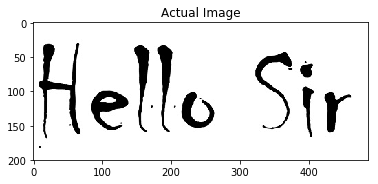

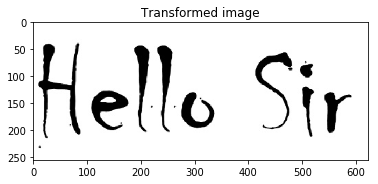

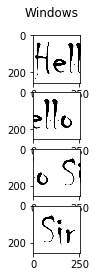

In [8]:
img = cv2.imread('test.jpg')
(h, w, c) = np.shape(img)

print("Dimensions before transformation : ", w, h)

if h < 256:
    ratio = 256 / h
    h = 256
    w = int(w * ratio)
else:
    ratio = h / 256
    h = 256
    w = int(w / ratio)

new_img = cv2.resize(img, (w, h))
windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)

print("Dimensions after transformation : ", w, h)

print(np.shape(img))
plt.imshow(img)
plt.title('Actual Image')
plt.show()

plt.imshow(new_img)
plt.title('Transformed image')
plt.show()

fig, axs = plt.subplots(len(windows))
fig.suptitle('Windows')
for i in range(0, len(windows)):
    axs[i].imshow(new_img[windows[i].indices()])

plt.show()

In [168]:
# Globals
batch_size = 8
epoch = 10

In [169]:
# Creating data generators feeding 8 images at a time
def train_generator(batch_number_train, train_x, train_y):
    start_index = (batch_number_train-1)*batch_size
    end_index = batch_number_train*batch_size-1
    x, y = [], []
    for i in range(start_index, end_index + 1):
        img = cv2.imread(train_x[i])
        (h, w, c) = np.shape(img)
        if h < 256:
            ratio = 256 / h
            h = 256
            w = int(w * ratio)
        else:
            ratio = h / 256
            h = 256
            w = int(w / ratio)
        new_img = cv2.resize(img, (w, h))
        windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)
        for j in range(0, len(windows)):
            x.append(new_img[windows[j].indices()])
            y.append(train_y[i])
    x = np.array(x, dtype='float32')
    x /= 255
    y = np.array(encoder.transform(y).toarray())
    return x, y

In [170]:
# Evalutating all the metrics using testing set
def validate(model, x, y):
    y_true, y_pred = [], []
    for i in range(0, len(x)):
        tx = []
        img = cv2.imread(x[i])
        (h, w, c) = np.shape(img)
        if h < 256:
            ratio = 256 / h
            h = 256
            w = int(w * ratio)
        else:
            ratio = h / 256
            h = 256
            w = int(w / ratio)
        new_img = cv2.resize(img, (w, h))
        windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)
        for j in range(0, len(windows)):
            tx.append(new_img[windows[j].indices()])
        tx = np.array(tx, dtype='float32')
        tx /= 255
        ty = model.predict(tx)
        final_sf = np.zeros(dtype='float32', shape=(10))
        for ti in range(0, len(ty)):
            for tj in range(0, 10):
                final_sf[tj] += ty[ti][tj]
        final_sf /= len(ty)
        final_sf = final_sf.reshape((-1, 10))
        y_pred.append(encoder.inverse_transform(final_sf)[0])
        y_true.append(y[i])
    print(confusion_matrix(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))

In [171]:
# Loading image destinations with their labels
path = 'data/CRYSTAL/'
files = [f for f in os.listdir(path)]
x, y = [], []
for i in range(0, len(files)):
    file_name = os.path.splitext(os.path.basename(files[i]))[0]
    y.append(file_name.split('_')[0])
    x.append(os.path.join(path, files[i]))
y = np.reshape(y, (-1, 1))

In [172]:
# Fit the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(y)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [173]:
# Split into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.02, random_state=44)
del x, y

In [174]:
# Create the model
model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizers.Adam(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        9248      
__________

In [175]:
# Train the model
for epoch_no in range(0, 5):
    for batch in range(1, len(train_x)//batch_size):
        if batch%10==0:
            print("Epoch : ", epoch_no, " Batch : ", batch)
        x, y = train_generator(batch, train_x, train_y)
        model.fit(x, y, verbose=0)

Epoch :  0  Batch :  10
Epoch :  0  Batch :  20
Epoch :  0  Batch :  30
Epoch :  0  Batch :  40
Epoch :  0  Batch :  50
Epoch :  0  Batch :  60
Epoch :  0  Batch :  70
Epoch :  0  Batch :  80
Epoch :  0  Batch :  90
Epoch :  0  Batch :  100
Epoch :  0  Batch :  110
Epoch :  0  Batch :  120
Epoch :  0  Batch :  130
Epoch :  0  Batch :  140
Epoch :  0  Batch :  150
Epoch :  0  Batch :  160
Epoch :  0  Batch :  170
Epoch :  0  Batch :  180
Epoch :  0  Batch :  190
Epoch :  0  Batch :  200
Epoch :  0  Batch :  210
Epoch :  0  Batch :  220
Epoch :  0  Batch :  230
Epoch :  0  Batch :  240
Epoch :  0  Batch :  250
Epoch :  0  Batch :  260
Epoch :  0  Batch :  270
Epoch :  0  Batch :  280
Epoch :  0  Batch :  290
Epoch :  0  Batch :  300
Epoch :  0  Batch :  310
Epoch :  0  Batch :  320
Epoch :  0  Batch :  330
Epoch :  0  Batch :  340
Epoch :  0  Batch :  350
Epoch :  0  Batch :  360
Epoch :  0  Batch :  370
Epoch :  0  Batch :  380
Epoch :  0  Batch :  390
Epoch :  0  Batch :  400
Epoch :  

KeyboardInterrupt: 

In [150]:
# Calculate the confusion matrix and AUC score
validate(model, test_x, test_y)

['forte']
[[0.13776551 0.07335757 0.09977169 0.10582538 0.11119664 0.0834967
  0.05029514 0.12353043 0.1251228  0.08963811]]
